<a href="https://colab.research.google.com/github/atkinsonde/524/blob/main/Extremes_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h4>additional resouce sites</h4>

https://www.ndsu.edu/pubweb/~sainieid/group/100-year.htm

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rank.html

https://data.library.virginia.edu/understanding-q-q-plots/

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html#scipy.stats.linregress


In [1]:
!git clone https://github.com/atkinsonde/524.git

Cloning into '524'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 117 (delta 8), reused 0 (delta 0), pack-reused 83
Receiving objects: 100% (117/117), 5.67 MiB | 14.06 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [2]:
# load all of the reqired libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy import stats


In [5]:
# import source data
df = pd.read_csv('/content/524/extremes/08LE021_Daily_Flow_ts.csv',
            parse_dates = ['Date'],
            usecols=['PARAM','Date','Flow']
            ) 

df = df.set_index('Date')

df.sort_index(inplace=True)


In [7]:
# restucture dataset for application
df1 = df['Flow'][df['PARAM']==1]

# here we are grouping our values by year and only using the max value in a given year
df1_max = df1.groupby(df1.index.year).max()

df1_sub = pd.DataFrame(df1_max)


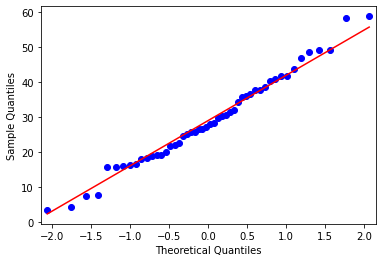

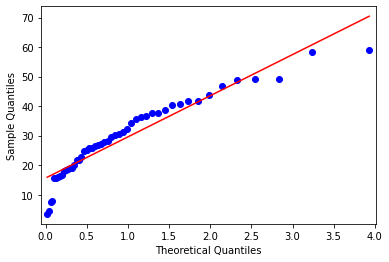

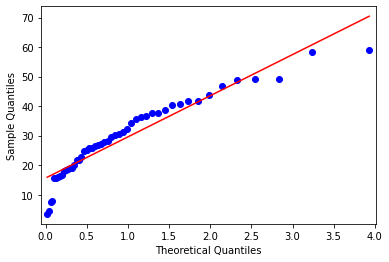

In [9]:
# generate qq plots for context and data exploration and visualization
from statsmodels.graphics.gofplots import qqplot

qqplot_data = qqplot(df1_sub.Flow, line='s').gca().lines

qqplot_data = qqplot(df1_sub.Flow, 
                     dist=stats.gamma,
                     distargs=([1]),
                     line='r').gca().lines

qqplot_data = qqplot(df1_sub.Flow[df1_sub.Flow<3000], 
                     dist=stats.gamma,
                     distargs=([1]),
                     line='r').gca().lines


In [10]:
# plotly version of the plot above
fig = go.Figure([
        go.Scatter(      
            x=qqplot_data[0].get_xdata(), y=qqplot_data[0].get_ydata(),
            mode='markers',opacity=0.65,line=dict(color='blue', width=2),
            name='data'
            ),
        go.Scatter(      
            x=qqplot_data[1].get_xdata(), y=qqplot_data[1].get_ydata(),
            mode='lines',line=dict(color='red', width=2),
            name='qq'
            )
        ])
fig.show()


<h6>next step is to calculate return interval for our dataset</h6>

For each data point, a Recurrence Interval (RI) is calculated using the Weibull equation

RI = (n+1)/m

the peak discharges are ranked from m = 1 (largest), m = 2 (second largest) and so on to m=n


In [11]:
# first get n value using the length function on our dataframe
n = len(df1_sub)


In [13]:
# next we create a column with a rank for our values
df1_sub['ranked'] = df1_sub['Flow'].rank(ascending=False ,method='first')


In [14]:
# once we have our n and m values we can create a column with RI's for our values
df1_sub['RI'] = (n + 1)/df1_sub['ranked']


In [15]:
# now we have all our data organized let's plot it!
Y = np.array(df1_sub['Flow'])
X = np.array(df1_sub.RI)

linear_res = stats.linregress(np.log(X), Y)
linear_res_y = linear_res.intercept + linear_res.slope * np.log(X)

fig = go.Figure()

fig.add_trace(go.Scatter(mode="markers", x=df1_sub.RI, y=df1_sub["Flow"]))

fig.add_trace(go.Scatter(mode="lines", x=df1_sub.RI, y=linear_res_y))

fig.update_xaxes(type="log",range=[0,2])

fig.show()


In [23]:
# now we have our linear regression set let's make some predictions

# discharge prediction
year_return = 100
predict_value = linear_res.intercept + linear_res.slope * np.log(year_return)

print('full dataset predicted discharge for 1/{} years equals {:.0f} m^3/s'.format(year_return,predict_value))

# year prediction
future_value = 120
predict_year = np.exp((future_value - linear_res.intercept)/linear_res.slope)

print('full dataset predicted discharge for 1/{:.0f} years equals {} m^3/s'.format(predict_year,future_value))


full dataset predicted discharge for 1/100 years equals 80 m^3/s
full dataset predicted discharge for 1/1783 years equals 120 m^3/s


<h3>after reviewing the plots above it is clear that it is probably best to revome the extreme outlier value from our data and regenerate our linear regression calculation</h3>

In [18]:
# trim the dataset to only include values under 3000
data = pd.DataFrame(df1_max)
data = data[data.Flow < 3000]
#df1_sub = df1_sub.sort_values(by='ranked')

# as we did above let's recalculate our RI's
n = len(data)
data['ranked'] = data['Flow'].rank(ascending=False ,method='first')
data['RI'] = (n + 1)/data['ranked']


In [19]:
# now we have removed the extreme outlier let's re-plot it!
Y = np.array(data['Flow'])
X = np.array(data.RI)

linear_res = stats.linregress(np.log(X), Y)
linear_res_y = linear_res.intercept + linear_res.slope * np.log(X)

fig = go.Figure()

fig.add_trace(go.Scatter(mode="markers", x=data.RI, y=data["Flow"]))

fig.add_trace(go.Scatter(mode="lines", x=data.RI, y=linear_res_y))

fig.update_xaxes(type="log",range=[0,2])

fig.show()


In [24]:
# now we have removed the extreme outlier from our dataset and 
# recalculated our linear regression set let's redo our predictions

# discharge prediction
year_return = 100
predict_value = linear_res.intercept + linear_res.slope * np.log(year_return)

print('trimmed dataset predicted discharge for 1/{} years equals {:.0f} m^3/s'.format(year_return,predict_value))

# year prediction
future_value = 110
predict_year = np.exp((future_value - linear_res.intercept)/linear_res.slope)

print('trimmed dataset predicted discharge for 1/{:.0f} years equals {} m^3/s'.format(predict_year,future_value))


trimmed dataset predicted discharge for 1/100 years equals 80 m^3/s
trimmed dataset predicted discharge for 1/870 years equals 110 m^3/s
